In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path

pd.set_option('precision', 2)
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

In [2]:
data_folder = "../data"
web_data = "web_page_data.csv"

In [3]:
session_times = pd.read_csv(Path(data_folder) / web_data)
session_times.loc[:, 'Time'] *= 100.

In [4]:
session_times.tail()

,Page,Time
31,Page A,74.0
32,Page A,86.0
33,Page A,118.0
34,Page A,206.0
35,Page A,93.0


In [5]:
session_times.groupby('Page').describe()

Time                                                 
       count    mean     std   min   25%    50%    75%    max
Page                                                         
Page A  21.0  126.33   88.46  21.0  67.0   95.0  173.0  342.0
Page B  15.0  162.00  101.14  43.0  80.0  147.0  234.5  357.0

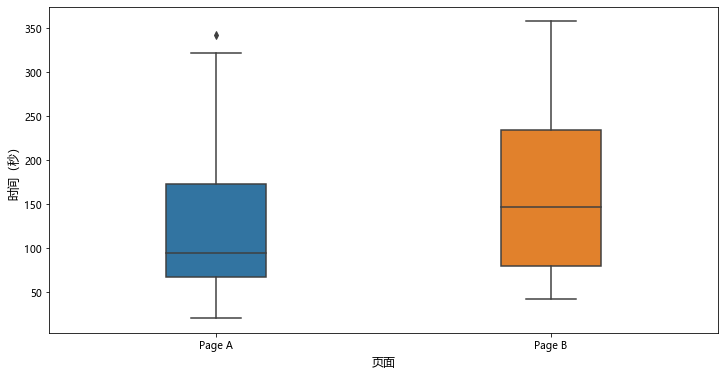

In [6]:
# Figure 3.3

fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(x='Page', y='Time', data=session_times, width=0.3, ax=ax)
ax.set_xlabel('页面', fontsize=12)
ax.set_ylabel('时间（秒）', fontsize=12)
pass

In [7]:
def permutation(arr, n1, n2):
    n = n1 + n2
    arr = np.random.permutation(arr)
    return arr[:n1], arr[n1:]

In [8]:
info_table = session_times.groupby('Page').agg(['count', 'mean'])
mean_diff = info_table.loc['Page B', ('Time', 'mean')] - info_table.loc['Page A', ('Time', 'mean')]

n_perm = 5000
session_values = session_times['Time'].values
n_A = int(info_table.loc['Page A', ('Time', 'count')])
n_B = int(info_table.loc['Page B', ('Time', 'count')])

sampled_mean_diff = []
for _ in range(n_perm):
    perm_A, perm_B = permutation(session_values, n_A, n_B)
    mean_diff_perm = np.mean(perm_B) - np.mean(perm_A)
    sampled_mean_diff.append(mean_diff_perm)

In [9]:
def plot_hist(data, axv_line, ax, x_label, is_cum=False):
    if is_cum:
        sns.distplot(data, bins=50, norm_hist=True, hist_kws={'cumulative': True}, kde=False, ax=ax)
        ax.set_ylabel('累积概率', fontsize=12)
        ax.set_yticks(np.linspace(0., 1., 11))
    else:
        sns.distplot(data, bins=50, ax=ax)
        ax.set_ylabel('概率', fontsize=12)
    ax.set_xlabel(x_label, fontsize=12)
    ax.axvline(axv_line, color='k')
    ax.grid()

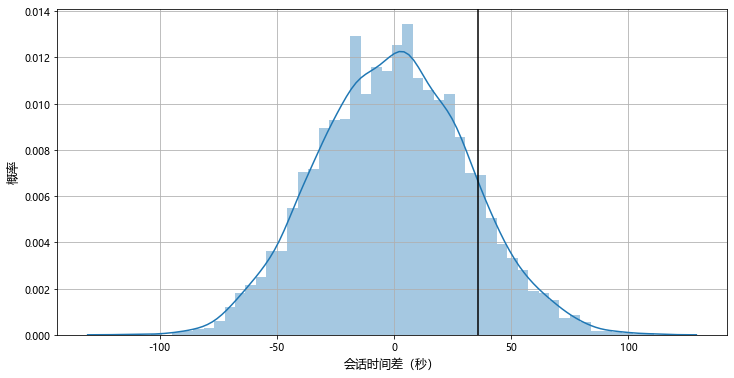

In [10]:
# Figure 3.4
fig, ax = plt.subplots(figsize=(12, 6))
plot_hist(sampled_mean_diff, mean_diff, ax, x_label='会话时间差（秒）')

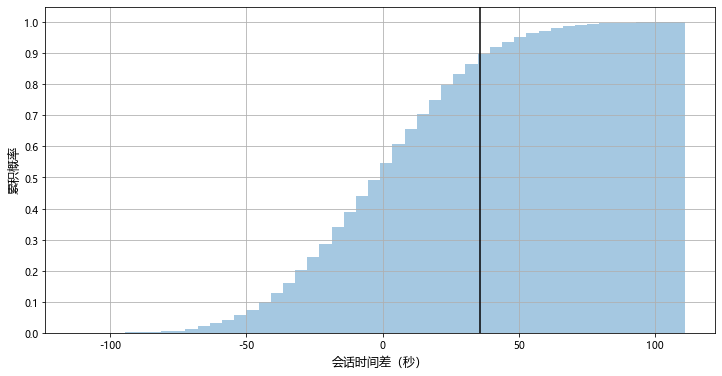

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_hist(sampled_mean_diff, mean_diff, ax, x_label='会话时间差（秒）', is_cum=True)

In [19]:
n_A = 22588
n_B = 23739
cn_A = 182
cn_B = 200

conversion_rate_A = cn_A / n_A * 100.
conversion_rate_B = cn_B / n_B * 100.
conversion_rate_diff = conversion_rate_B - conversion_rate_A

print(f"页面A的转化率: {conversion_rate_A:.2f}%")
print(f"页面B的转化率: {conversion_rate_B:.2f}%")
print(f"页面转化率变化: {conversion_rate_diff :.2f}%")
print(f"页面转化率相对变化: {conversion_rate_diff / conversion_rate_A * 100.:.2f}%")

页面A的转化率: 0.81%
页面B的转化率: 0.84%
页面转化率变化: 0.04%
页面转化率相对变化: 4.56%


In [14]:
n_perm = 5000
sampled_conversion_diff = []
num_un_converted = n_A + n_B - cn_A - cn_B
num_converted = cn_A + cn_B
conversion_values = np.concatenate([np.zeros(num_un_converted), np.ones(num_converted)])
for _ in range(n_perm):
    perm_A, perm_B = permutation(conversion_values, n_A, n_B)
    mean_conversion_perm = np.mean(perm_B) * 100. - np.mean(perm_A) * 100.
    sampled_conversion_diff.append(mean_conversion_perm)

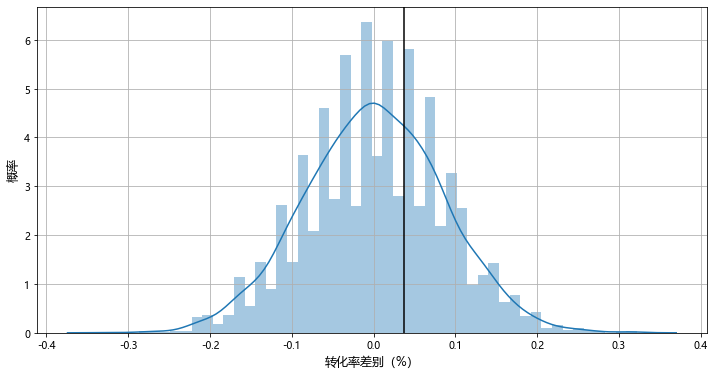

In [15]:
# Figure 3.5

fig, ax = plt.subplots(figsize=(12, 6))
plot_hist(sampled_conversion_diff, conversion_rate_diff, ax, x_label='转化率差别（%）')

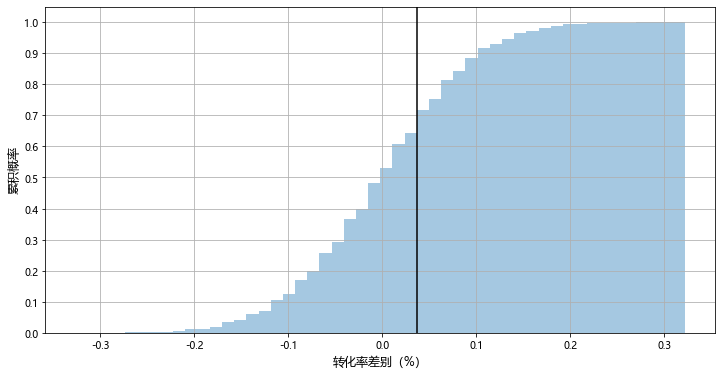

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_hist(sampled_conversion_diff, conversion_rate_diff, ax, x_label='转化率差别（%）', is_cum=True)

In [17]:
pd.Series(sampled_conversion_diff).to_csv('tmp.csv')

D:\ProgramData\Anaconda3\envs\statistics\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


# of samples: 46327; Q.: 0.6432
# of samples: 92654; Q.: 0.724
# of samples: 185308; Q.: 0.8112
# of samples: 370616; Q.: 0.8932
# of samples: 741232; Q.: 0.953
# of samples: 1482464; Q.: 0.9914
# of samples: 2964928; Q.: 0.9998


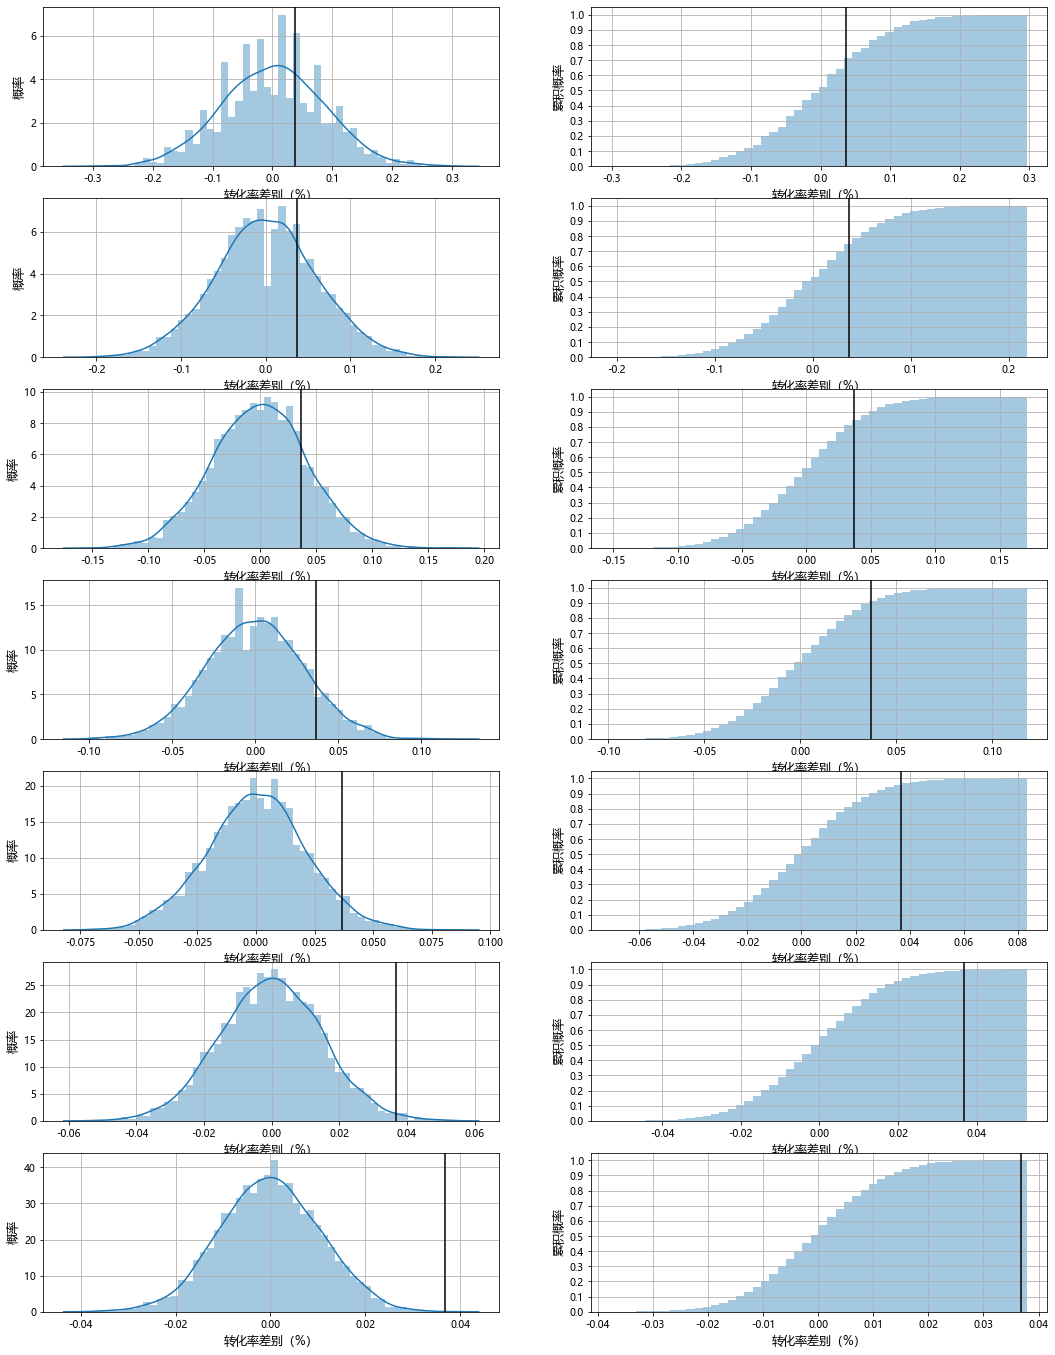

In [20]:
num_fold = 7
num_un_converted = n_A + n_B - cn_A - cn_B
num_converted = cn_A + cn_B
conversion_values = np.concatenate([np.zeros(num_un_converted), np.ones(num_converted)])

fig, axes = plt.subplots(nrows=num_fold, ncols=2, figsize=(18, 24))
covdiff_experiments = []

for i in range(num_fold):
    n_perm = 5000
    sampled_conversion_diff = []
    factor = 2 ** i
    new_num_un_converted = num_un_converted * factor
    new_num_converted = num_converted * factor
    new_n_A = n_A * factor
    new_n_B = n_B * factor
    conversion_values = np.concatenate([np.zeros(new_num_un_converted), np.ones(new_num_converted)])
    for _ in range(n_perm):
        perm_A, perm_B = permutation(conversion_values, new_n_A, new_n_B)
        mean_conversion_perm = np.mean(perm_B) * 100. - np.mean(perm_A) * 100.
        sampled_conversion_diff.append(mean_conversion_perm)
    
    covdiff_experiments.append(sampled_conversion_diff)
    ax = axes[i, 0]
    plot_hist(sampled_conversion_diff, conversion_rate_diff, ax, x_label='转化率差别（%）')
    
    ax = axes[i, 1]
    plot_hist(sampled_conversion_diff, conversion_rate_diff, ax, x_label='转化率差别（%）', is_cum=True)
    
    print(f"# of samples: {new_num_un_converted + new_num_converted}; Q.: {sum(conversion_rate_diff > np.array(sampled_conversion_diff)) / len(sampled_conversion_diff)}")

In [22]:
for data in covdiff_experiments:
    print(f"\nCurrent : {conversion_rate_diff:.2f}%; \
          Rel. {conversion_rate_diff / conversion_rate_A * 100.:.2f}%")
    print(f"95% Sig.: {np.quantile(data, 0.95):.2f}%; \
          Rel. {np.quantile(data, 0.95) / conversion_rate_A * 100.:.2f}%")
    print(f"99% Sig.: {np.quantile(data, 0.99):.2f}%; \
          Rel. {np.quantile(data, 0.99) / conversion_rate_A * 100.:.2f}%")


Current : 0.04%;           Rel. 4.56%
95% Sig.: 0.14%;           Rel. 17.43%
99% Sig.: 0.20%;           Rel. 24.93%

Current : 0.04%;           Rel. 4.56%
95% Sig.: 0.10%;           Rel. 12.60%
99% Sig.: 0.14%;           Rel. 17.43%

Current : 0.04%;           Rel. 4.56%
95% Sig.: 0.07%;           Rel. 8.58%
99% Sig.: 0.10%;           Rel. 12.34%

Current : 0.04%;           Rel. 4.56%
95% Sig.: 0.05%;           Rel. 6.04%
99% Sig.: 0.07%;           Rel. 8.45%

Current : 0.04%;           Rel. 4.56%
95% Sig.: 0.04%;           Rel. 4.43%
99% Sig.: 0.05%;           Rel. 6.44%

Current : 0.04%;           Rel. 4.56%
95% Sig.: 0.02%;           Rel. 3.05%
99% Sig.: 0.04%;           Rel. 4.39%

Current : 0.04%;           Rel. 4.56%
95% Sig.: 0.02%;           Rel. 2.17%
99% Sig.: 0.02%;           Rel. 2.92%
